#GPU使用時間と種類を表示

In [ ]:
res = sp.Popen(["cat", "/proc/uptime"], stdout=sp.PIPE)
    # 単位はHour
use_time = float(sp.check_output(["awk", "{print $1 /60 /60 }"], stdin=res.stdout).decode().replace("\n",""))
print(use_time)

0.171642


In [ ]:
!nvidia-smi

#ライブラリインポート


In [ ]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
import subprocess as sp
from datetime import datetime, timedelta, timezone
import math
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import imageio
import datetime
vgg19 = models.vgg19(pretrained=True)

#マウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#パラメータ定義

In [ ]:
%cd drive/My\ Drive
#dataroot1="verygood_smis_left-shoes"
#dataroot2="new_smis_left-shoes_mask"
dataroot3="color_pants"
dataroot4="verygood_smis_pants_mask"
#dataroot5="new_smis_right-shoes"
#dataroot6="new_smis_right-shoes_mask"
dataroot7="color_skirt"
dataroot8="verygood_smis_skirt_mask"
dataroot9="color_tops"
dataroot10="verygood_smis_tops_mask"
dataroot11="color_persons"
num_thread=0
batch_size=16
num_epoch=15
img_size=(128,96)
lr=0.0002
b1=0.5
b2=0.999
ngpu=1

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [ ]:
res = sp.Popen(["cat", "/proc/uptime"], stdout=sp.PIPE)
    # 単位はHour
use_time = float(sp.check_output(["awk", "{print $1 /60 /60 }"], stdin=res.stdout).decode().replace("\n",""))
print(use_time)

0.713381


#データのロード


In [ ]:
pants_dataset=dset.ImageFolder(root=dataroot3,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
pants_mask_dataset=dset.ImageFolder(root=dataroot4,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
skirt_dataset=dset.ImageFolder(root=dataroot7,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
skirt_mask_dataset=dset.ImageFolder(root=dataroot8,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
tops_dataset=dset.ImageFolder(root=dataroot9,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
tops_mask_dataset=dset.ImageFolder(root=dataroot10,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
person_dataset=dset.ImageFolder(root=dataroot11,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))

pants_dataloader=torch.utils.data.DataLoader(pants_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)    
pants_mask_dataloader=torch.utils.data.DataLoader(pants_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
skirt_dataloader=torch.utils.data.DataLoader(skirt_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
skirt_mask_dataloader=torch.utils.data.DataLoader(skirt_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
tops_dataloader=torch.utils.data.DataLoader(tops_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
tops_mask_dataloader=torch.utils.data.DataLoader(tops_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
person_dataloader=torch.utils.data.DataLoader(person_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)


device=torch.device("cuda:0")
print(len(person_dataset))
print(len(tops_dataset))
print(len(tops_mask_dataset))
print(len(skirt_dataset))
print(len(skirt_mask_dataset))
print(len(pants_dataset))
print(len(pants_mask_dataset))


2126
2126
2126
2126
2126
2126
2126


In [ ]:
device=torch.device("cuda:0")

#関数定義

##切り抜き

In [ ]:
def overlay(p,f,tops,pants,skirt):
  Mask=(tops+pants+skirt)
  Mask=MaskTrans(Mask)
  #print(Mask.size())
  #print(p.size())
  reverse=1-Mask
  cutout1=p*reverse
  #print(f[0][0][113][50],Mask[0][0][113][50])
  cutout2=Mask*f
  #print(cutout2[0][0][113][50])
  out=cutout1+cutout2
  return out

##mask閾値

In [ ]:
def  MaskTrans(mask):
  for i in range(mask.size(0)):
    for j in range(mask.size(1)):
      for k in range(mask.size(2)):
        for l in range(mask.size(3)):
          if mask[i][j][k][l]>0.6:
            mask[i][j][k][l]=1
          else:
            mask[i][j][k][l]=0
  
  return mask

##重みの初期化

In [ ]:
def init_weights(model):
  if isinstance(model.modules,nn.Conv2d):
      model.modules().weight.data.nomal_(0,0.002)
      model.modules().bias.data.zero_()
  if isinstance(model.modules,nn.ConvTranspose2d):
      model.modules().weight.data.nomal_(0,0.002)
      model.modules().bias.data.zero_()

##KLDloss


In [ ]:
def KLDloss(mu, logvar):
  lamda=0.05
  return lamda*(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()))

##Featloss


In [ ]:
def Featloss(t,f):
  L1=nn.L1Loss()
  lamda=10
  size=len(t)
  featloss = torch.full((1,), fill_value=0,dtype=torch.float32,device=device)

  for i in range(size):
    loss=L1(t[i].detach(),f[i])
    featloss+=(lamda*loss)

  return featloss

#クラス定義


##Encoder-Decoder



In [ ]:
class EncoderDecoder(nn.Module):
  def __init__(self,ngpu):
    super(EncoderDecoder,self).__init__()
    self.ngpu=ngpu
    #Encoder
    df=3#class
    self.down1_1=nn.Conv2d(3*df,32*df,3,2,1,bias=False,groups=3)
    self.innorm1_1=nn.InstanceNorm2d(32*df,eps=1e-5)

    self.Leaky=nn.LeakyReLU(0.2,inplace=True)
    self.down1_2=nn.Conv2d(32*df,64*df,3,2,1,bias=False,groups=3)
    self.innorm1_2=nn.InstanceNorm2d(64*df,eps=1e-5)

    self.down1_3=nn.Conv2d(64*df,128*df,3,2,1,bias=False,groups=3)
    self.innorm1_3=nn.InstanceNorm2d(128*df,eps=1e-5)

    self.down1_4=nn.Conv2d(128*df,256*df,3,2,1,bias=False,groups=3)
    self.innorm1_4=nn.InstanceNorm2d(256*df,eps=1e-5)

    self.gamma=nn.Conv2d(256*df,8*df,3,2,1,bias=False)
    self.beta=nn.Conv2d(256*df,8*df,3,2,1,bias=False)




    #Decoder
    self.down1_0=nn.Conv2d(8*df,320*df,3,1,1,groups=3)
    
    #1block
    self.batch1_1=nn.BatchNorm2d(320*df,eps=1e-5)
    self.pool1_1=nn.MaxPool2d(32)
    self.share1_1=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.relu=nn.ReLU()
    self.gamma1_1=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.beta1_1=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.leaky=nn.LeakyReLU(0.2)
    self.gconv1_1=nn.Conv2d(320*df,320*df,3,1,1,groups=3)

    self.batch1_2=nn.BatchNorm2d(320*df,eps=1e-5)
    self.pool1_2=nn.MaxPool2d(32)
    self.share1_2=nn.Conv2d(df*1,16*df,3,1,1,groups=3)
    self.gamma1_2=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.beta1_2=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.gconv1_2=nn.Conv2d(320*df,320*df,3,1,1,groups=3)
    self.unpool1_2=nn.Upsample(scale_factor=2,mode="nearest")


    #2block
    self.batch2_1=nn.BatchNorm2d(320*df,eps=1e-5)
    self.pool2_1=nn.MaxPool2d(16)
    self.share2_1=nn.Conv2d(df*1,16*df,3,1,1,groups=3)
    self.gamma2_1=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.beta2_1=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.gconv2_1=nn.Conv2d(320*df,320*df,3,1,1,groups=3)

    self.batch2_2=nn.BatchNorm2d(320*df)
    self.pool2_2=nn.MaxPool2d(16)
    self.share2_2=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma2_2=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.beta2_2=nn.Conv2d(16*df,320*df,3,1,1,groups=3)
    self.gconv2_2=nn.Conv2d(320*df,320*df,3,1,1,groups=3)
    self.unpool2_2=nn.Upsample(scale_factor=2,mode="nearest")


    #3block
    self.batch3_1=nn.BatchNorm2d(320*df,eps=1e-5)
    self.pool3_1=nn.MaxPool2d(8)
    self.share3_1=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma3_1=nn.Conv2d(16*df,320*df,3,1,1,groups=2)
    self.beta3_1=nn.Conv2d(16*df,320*df,3,1,1,groups=2)
    self.gconv3_1=nn.Conv2d(320*df,160*df,3,1,1,groups=2)

    self.batch3_2=nn.BatchNorm2d(160*df,eps=1e-5)
    self.pool3_2=nn.MaxPool2d(8)
    self.share3_2=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma3_2=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.beta3_2=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.gconv3_2=nn.Conv2d(160*df,160*df,3,1,1,groups=2)
    self.unpool3_2=nn.Upsample(scale_factor=2,mode="nearest")
    
    self.batch3_3=nn.BatchNorm2d(320*df,eps=1e-5)
    self.pool3_3=nn.MaxPool2d(8)
    self.share3_3=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma3_3=nn.Conv2d(16*df,320*df,3,1,1,groups=2)
    self.beta3_3=nn.Conv2d(16*df,320*df,3,1,1,groups=2)
    self.gconv3_3=nn.Conv2d(320*df,160*df,3,1,1,groups=2)
    #self.unpool3_3=nn.MaxUnpool2d(2)


    #4block
    self.batch4_1=nn.BatchNorm2d(160*df,eps=1e-5)
    self.pool4_1=nn.MaxPool2d(4)
    self.share4_1=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma4_1=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.beta4_1=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.gconv4_1=nn.Conv2d(160*df,80*df,3,1,1,groups=2)

    self.batch4_2=nn.BatchNorm2d(80*df,eps=1e-5)
    self.pool4_2=nn.MaxPool2d(4)
    self.share4_2=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma4_2=nn.Conv2d(16*df,80*df,3,1,1,groups=2)
    self.beta4_2=nn.Conv2d(16*df,80*df,3,1,1,groups=2)
    self.gconv4_2=nn.Conv2d(80*df,80*df,3,1,1,groups=2)
    self.unpool4_2=nn.Upsample(scale_factor=4,mode="nearest")
    
    self.batch4_3=nn.BatchNorm2d(160*df,eps=1e-5)
    self.pool4_3=nn.MaxPool2d(4)
    self.share4_3=nn.Conv2d(1*df,16*df,3,1,1,groups=3)
    self.gamma4_3=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.beta4_3=nn.Conv2d(16*df,160*df,3,1,1,groups=2)
    self.gconv4_3=nn.Conv2d(160*df,80*df,1,1,0,groups=2)
    #self.unpool4_3=nn.MaxUnpool2d(2)

    #5block
    self.batch5_1=nn.BatchNorm2d(80*df,eps=1e-5)
    self.pool5_1=nn.MaxPool2d(1)
    self.share5_1=nn.Conv2d(1*df,16*df,3,1,1,groups=1)
    self.gamma5_1=nn.Conv2d(16*df,80*df,3,1,1,groups=1)
    self.beta5_1=nn.Conv2d(16*df,80*df,3,1,1,groups=1)
    self.gconv5_1=nn.Conv2d(80*df,20*df,3,1,1,groups=1)

    self.batch5_2=nn.BatchNorm2d(20*df,eps=1e-5)
    self.pool5_2=nn.MaxPool2d(1)
    self.share5_2=nn.Conv2d(1*df,16*df,3,1,1,groups=1)
    self.gamma5_2=nn.Conv2d(16*df,20*df,3,1,1,groups=1)
    self.beta5_2=nn.Conv2d(16*df,20*df,3,1,1,groups=1)
    self.gconv5_2=nn.Conv2d(20*df,20*df,3,1,1,groups=1)
    #self.unpool5_2=nn.MaxUnpool2d(2)
    
    self.batch5_3=nn.BatchNorm2d(80*df,eps=1e-5)
    self.pool5_3=nn.MaxPool2d(1)
    self.share5_3=nn.Conv2d(1*df,16*df,3,1,1,groups=1)
    self.gamma5_3=nn.Conv2d(16*df,80*df,3,1,1,groups=1)
    self.beta5_3=nn.Conv2d(16*df,80*df,3,1,1,groups=1)
    self.gconv5_3=nn.Conv2d(80*df,20*df,1,1,0,groups=1)
    #self.unpool5_3=nn.MaxUnpool2d(2)

    #lastblock
    self.lastconv=nn.Conv2d(20*df,3,3,1,1)
    self.sigmoid=nn.Sigmoid()

    


  def Encoder(self,input): 
    down1_1=self.down1_1(input)
    innorm1_1=self.innorm1_1(down1_1)
    #print(innorm1_1.size())

    leaky1_2=self.Leaky(innorm1_1)
    down1_2=self.down1_2(leaky1_2)
    innorm1_2=self.innorm1_2(down1_2)
    #print(innorm1_2.size())

    leaky1_3=self.Leaky(innorm1_2)
    down1_3=self.down1_3(leaky1_3)
    innorm1_3=self.innorm1_3(down1_3)
    #print(innorm1_3.size())

    leaky1_4=self.Leaky(innorm1_3)
    #print(leaky1_4.size())
    down1_4=self.down1_4(leaky1_4)
    innorm1_4=self.innorm1_4(down1_4)
    #print(innorm1_4.size())
    
    leaky1_5=self.Leaky(innorm1_4)
    #print(leaky1_5.size())
    gamma=self.gamma(leaky1_5)
    beta=self.beta(leaky1_5)
    #print(gamma.size(),beta.size())
    #print("---"*10)
    return gamma,beta




  def Decoder(self,z,seg): 
    down1_0=self.down1_0(z)
    

    #1block
    batch1_1=self.batch1_1(down1_0)
    share1_1=self.relu(self.share1_1(self.pool1_1(seg)))
    gamma1_1=self.gamma1_1(share1_1)
    beta1_1=self.beta1_1(share1_1)
    temp1_1=(batch1_1*gamma1_1)+beta1_1
    out1_1=self.gconv1_1(self.leaky(temp1_1))

    batch1_2=self.batch1_2(out1_1)
    share1_2=self.relu(self.share1_2(self.pool1_2(seg)))
    gamma1_2=self.gamma1_2(share1_2)
    beta1_2=self.beta1_2(share1_2)
    temp1_2=(batch1_2*gamma1_2)+beta1_2
    out1_2=self.unpool1_2(self.gconv1_2(self.leaky(temp1_2)))
    #print(out1_2.size())


    #2block
    batch2_1=self.batch2_1(out1_2)
    share2_1=self.relu(self.share2_1(self.pool2_1(seg)))
    gamma2_1=self.gamma2_1(share2_1)
    beta2_1=self.beta2_1(share2_1)
    temp2_1=(batch2_1*gamma2_1)+beta2_1
    out2_1=self.gconv2_1(self.leaky(temp2_1))

    batch2_2=self.batch2_2(out2_1)
    share2_2=self.relu(self.share2_2(self.pool2_2(seg)))
    gamma2_2=self.gamma2_2(share2_2)
    beta2_2=self.beta2_2(share2_2)
    temp2_2=(batch2_2*gamma2_2)+beta2_2
    out2_2=self.unpool2_2(self.gconv2_2(self.leaky(temp2_2)))
    #print(out2_2.size())


    #3block
    batch3_1=self.batch3_1(out2_2)
    share3_1=self.relu(self.share3_1(self.pool3_1(seg)))
    gamma3_1=self.gamma3_1(share3_1)
    beta3_1=self.beta3_1(share3_1)
    temp3_1=(batch3_1*gamma3_1)+beta3_1
    out3_1=self.gconv3_1(self.leaky(temp3_1))

    batch3_2=self.batch3_2(out3_1)
    share3_2=self.relu(self.share3_2(self.pool3_2(seg)))
    gamma3_2=self.gamma3_2(share3_2)
    beta3_2=self.beta3_2(share3_2)
    temp3_2=(batch3_2*gamma3_2)+beta3_2
    out3_2=self.gconv3_2(self.leaky(temp3_2))

    batch3_3=self.batch3_3(out2_2)
    share3_3=self.relu(self.share3_3(self.pool3_3(seg)))
    gamma3_3=self.gamma3_3(share3_3)
    beta3_3=self.beta3_3(share3_3)
    temp3_3=(batch3_3*gamma3_3)+beta3_3
    out3_3=self.gconv3_3(self.leaky(temp3_3))
    out3=self.unpool3_2(out3_2+out3_3)
    #print(out3.size())


    #4block
    batch4_1=self.batch4_1(out3)
    share4_1=self.relu(self.share4_1(self.pool4_1(seg)))
    gamma4_1=self.gamma4_1(share4_1)
    beta4_1=self.beta4_1(share4_1)
    temp4_1=(batch4_1*gamma4_1)+beta4_1
    out4_1=self.gconv4_1(self.leaky(temp4_1))

    batch4_2=self.batch4_2(out4_1)
    share4_2=self.relu(self.share4_2(self.pool4_2(seg)))
    gamma4_2=self.gamma4_2(share4_2)
    beta4_2=self.beta4_2(share4_2)
    temp4_2=(batch4_2*gamma4_2)+beta4_2
    out4_2=self.gconv4_2(self.leaky(temp4_2))

    batch4_3=self.batch4_3(out3)
    share4_3=self.relu(self.share4_3(self.pool4_3(seg)))
    gamma4_3=self.gamma4_3(share4_3)
    beta4_3=self.beta4_3(share4_3)
    temp4_3=(batch4_3*gamma4_3)+beta4_3
    #print(temp4_3.size())
    out4_3=self.gconv4_3(self.leaky(temp4_3))
    #print(out4_2.size(),out4_3.size())
    out4=self.unpool4_2(out4_2+out4_3)
    #print(out4.size())

    #5block
    batch5_1=self.batch5_1(out4)
    share5_1=self.relu(self.share5_1(self.pool5_1(seg)))
    gamma5_1=self.gamma5_1(share5_1)
    beta5_1=self.beta5_1(share5_1)
    #print(gamma5_1.size(),batch5_1.size())
    temp5_1=(batch5_1*gamma5_1)+beta5_1
    out5_1=self.gconv5_1(self.leaky(temp5_1))

    batch5_2=self.batch5_2(out5_1)
    share5_2=self.relu(self.share5_2(self.pool5_2(seg)))
    gamma5_2=self.gamma5_2(share5_2)
    beta5_2=self.beta5_2(share5_2)
    temp5_2=(batch5_2*gamma5_2)+beta5_2
    out5_2=self.gconv5_2(self.leaky(temp5_2))

    batch5_3=self.batch5_3(out4)
    share5_3=self.relu(self.share5_3(self.pool5_3(seg)))
    gamma5_3=self.gamma5_3(share5_3)
    beta5_3=self.beta5_3(share5_3)
    temp5_3=(batch5_3*gamma5_3)+beta5_3
    out5_3=self.gconv5_3(self.leaky(temp5_3))
    out5=self.sigmoid(self.lastconv(self.leaky(out5_2+out5_3)))

    return out5


  def reparameterize(self,mu, logvar):
      std = torch.exp(0.5 * logvar) #分散共分散のlogvarを標準偏差stdに変換
      #print(std.size())
      eps = torch.randn_like(std)
      #print(mu)
      #print(eps.mul(std) + mu)
      return eps.mul(std) + mu


  def forward(self,input,seg,Z,test=False,pre=False,encodeonly=False):
    if not test and not pre and not encodeonly:
      mu,logvar=self.Encoder(input)
      z=self.reparameterize(mu,logvar)
      #print(input.size(),seg.size())
      fake=self.Decoder(z,seg)
      return fake,mu,logvar,z
    
    elif pre==True:
      fake=self.Decoder(Z,seg)
      return fake

    elif encodeonly==True:
      mu,logvar=self.Encoder(input)
      z=self.reparameterize(mu,logvar)
      return z

    else:
      z=torch.randn((seg.size(0),24,4,3)).to(device)
      fake=self.Decoder(z,seg)
      return fake,z

##Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__(self,ngpu):    
    super(Discriminator,self).__init__()
    self.ngpu=ngpu
    df=3
    dc=df+3#class
    #1block
    self.pool=nn.AvgPool2d(2)
    self.down1_1=nn.Conv2d(dc,8*dc,4,2,2)
    self.leaky=nn.LeakyReLU(0.2)

    #2block
    self.down1_2=nn.Conv2d(8*dc,16*dc,4,2,2)
    self.innorm1_2=nn.InstanceNorm2d(16*dc)

    #3block
    self.down1_3=nn.Conv2d(16*dc,32*dc,4,2,2)
    self.innorm1_3=nn.InstanceNorm2d(32*dc)

    #4block
    self.down1_4=nn.Conv2d(32*dc,64*dc,4,1,2)
    self.innorm1_4=nn.InstanceNorm2d(64*dc)

    #5block
    self.down1_5=nn.Conv2d(64*dc,1,4,1,2)
    self.sigmoid=nn.Sigmoid()

  def Discriminator(self,image,seg): 
    #print(image.size(),seg.size())
    featmap=[]
    data=torch.cat([image,seg],dim=1)
    
    #1block
    pool1_1=self.pool(data)
    down1_1=self.down1_1(pool1_1)
    leaky1_1=self.leaky(down1_1)
    featmap.append(leaky1_1)
    #print(leaky1_1.size())

    #2block
    down1_2=self.down1_2(leaky1_1)
    innorm1_2=self.innorm1_2(down1_2)
    leaky1_2=self.leaky(innorm1_2)
    featmap.append(leaky1_2)
    #print(leaky1_2.size())

    #3block
    down1_3=self.down1_3(leaky1_2)
    innorm1_3=self.innorm1_3(down1_3)
    leaky1_3=self.leaky(innorm1_3)
    featmap.append(leaky1_3)
    #print(leaky1_3.size())



    #4block
    down1_4=self.down1_4(leaky1_3)
    innorm1_4=self.innorm1_4(down1_4)
    leaky1_4=self.leaky(innorm1_4)
    featmap.append(leaky1_4)
    #print(leaky1_4.size())

    down1_5=self.down1_5(leaky1_4)
    #print(down1_5.size())
    #print("---"*10)

    return self.sigmoid(down1_5),featmap

##知覚損失(/有)


In [ ]:
class Vgg19Loss(nn.Module):
    def __init__(self):
        super(Vgg19Loss, self).__init__()
        features1=list(vgg19.features)[:3]
        features2=list(vgg19.features)[:8]
        features3=list(vgg19.features)[:13]
        features4=list(vgg19.features)[:22]
        features5=list(vgg19.features)[:31]
        self.features1=nn.ModuleList(features1).eval()
        self.features2=nn.ModuleList(features2).eval()
        self.features3=nn.ModuleList(features3).eval()
        self.features4=nn.ModuleList(features4).eval()
        self.features5=nn.ModuleList(features5).eval()

    def forward(self,x,y):
        t1=x
        t2=y
        loss1=nn.MSELoss()
        loss2=nn.MSELoss()
        loss3=nn.MSELoss()
        loss4=nn.MSELoss()
        loss5=nn.MSELoss()

        for f in self.features1:
            x=f(x)
            y=f(y)
        #print(x,y)
        f1loss=torch.sqrt(loss1(x,y)/(64*128*96))
    
        
        x=t1
        y=t2
        for f in self.features2:
            x=f(x)
            y=f(y)
       # print(x.size(),y.size())
        f2loss=torch.sqrt(loss2(x,y)/(128*64*48))

        x=t1
        y=t2
        for f in self.features3:
            x=f(x)
            y=f(y)
       # print(x.size(),y.size())
        f3loss=torch.sqrt(loss3(x,y)/(256*32*24))

        x=t1
        y=t2
        for f in self.features4:
            x=f(x)
            y=f(y)
        #print(x.size(),y.size())
        f4loss=torch.sqrt(loss4(x,y)/(512*16*12))

        x=t1
        y=t2
        for f in self.features5:
            x=f(x)
            y=f(y)
        #print(x.size(),y.size())
        f5loss=torch.sqrt(loss5(x,y)/(512*8*6))
        lamda=10
        #print((f1loss+f2loss+f3loss+f4loss+f5loss))

        #return (f1loss+f2loss+f3loss+f4loss+f5loss)*10
        return (f1loss+f2loss+f3loss+f4loss+f5loss)*10

#Encoder-Decoder,Discriminatorの初期化

In [ ]:
netG=EncoderDecoder(ngpu).to(device)
netG.apply(init_weights)

netD=Discriminator(ngpu).to(device)
netD.apply(init_weights)

Discriminator(
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (down1_1): Conv2d(6, 48, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (leaky): LeakyReLU(negative_slope=0.2)
  (down1_2): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (innorm1_2): InstanceNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (down1_3): Conv2d(96, 192, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (innorm1_3): InstanceNorm2d(192, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (down1_4): Conv2d(192, 384, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (innorm1_4): InstanceNorm2d(384, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (down1_5): Conv2d(384, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (sigmoid): Sigmoid()
)

#Adam最適化＆損失関数

In [ ]:
L1=nn.L1Loss()
Lper=Vgg19Loss().to(device)
Ladv=nn.BCELoss()


real_label=1
fake_label=0

optimizernetG=optim.Adam(netG.parameters(),lr=lr,betas=(b1,b2))
optimizernetD=optim.Adam(netD.parameters(),lr=lr,betas=(b1,b2))

#学習

##本番

In [ ]:
Generator_losses=[]
Discriminator_losses = []
Sum_losses = []
kld_losses=[]
vgg_losses=[]
feat_losses=[]
L1_losses=[]
judge1=[]
judge2=[]
judge3=[]
epoch=0

In [ ]:
i=0
t1=time.time()
for epoch in range(100):
   iter_tops = iter(tops_dataloader)
   iter_pants=iter(pants_dataloader)
   iter_skirt = iter(skirt_dataloader)
   iter_person=iter(person_dataloader)

   iter_tops_mask = iter(tops_mask_dataloader)
   iter_pants_mask=iter(pants_mask_dataloader)
   iter_skirt_mask= iter(skirt_mask_dataloader)


   t1=time.time()
   for tops_data in tops_dataloader:
        #0.バッチデータの取得     
        tops_real_batch=next(iter_tops)
        pants_real_batch=next(iter_pants)
        skirt_real_batch=next(iter_skirt)
        person_real_batch=next(iter_person)

        tops_mask_real_batch=next(iter_tops_mask)
        pants_mask_real_batch=next(iter_pants_mask)
        skirt_mask_real_batch=next(iter_skirt_mask)
       
        tops=tops_real_batch[0].to(device)              #[][][][]
        pants=pants_real_batch[0].to(device)      #[][][][]
        skirt=skirt_real_batch[0].to(device)  
        person=person_real_batch[0].to(device)

        tops_mask=tops_mask_real_batch[0].to(device)              #[][][][]
        pants_mask=pants_mask_real_batch[0].to(device)      #[][][][]
        skirt_mask=skirt_mask_real_batch[0].to(device)  


        b_size = tops.size(0)#バッチサイズを計算
        #print(b_size)
        
        
        #データの連結
        input=torch.cat([tops,pants,skirt],dim=1)
        seg=torch.cat([tops_mask,pants_mask,skirt_mask],dim=1)
        
        for j in range(1):
          #fakeを生成
          
          fake,mu,logvar,_=netG(input,seg,_)
          #break
          
          #fake_image=overlay(person,fake,tops_mask,pants_mask,skirt_mask)
          

          #Discriminator
          netD.zero_grad()
          item=tops+pants+skirt
          
          pre_t,featmap_t=netD.Discriminator(item,seg)#正解データ
          judge1.append(pre_t.mean())
          label = torch.full(pre_t.size(), fill_value=real_label,dtype=torch.float32,device=device)#正解ラベルを設定
          D_loss_t = Ladv(pre_t,label)
          D_loss_t.backward()

          pre_f,featmap_f=netD.Discriminator(fake.detach(),seg)#偽物データ
          judge2.append(pre_f.mean())
          label.fill_(fake_label)#偽物ラベルを設定
          D_loss_f= Ladv(pre_f,label)
          D_loss_f.backward()
          D_loss=D_loss_t+D_loss_f
          optimizernetD.step()
          #print(2)

          
          #Generator
          if i%1==0:
            netG.zero_grad()
            label.fill_(real_label)#正解ラベルを設定
            pre_Gf,featmap_f=netD.Discriminator(fake,seg)#偽物データ

            ##各種損失
            G_loss_f = Ladv(pre_Gf,label)
            pre_t,featmap_t=netD.Discriminator(item,seg)#正解データ
            kld_loss=KLDloss(mu,logvar)

            L1_loss=L1(fake,item)*10
            vgg_loss=Lper(item,fake)

            kld_losses.append(kld_loss)
            vgg_losses.append(vgg_loss)
            L1_losses.append(L1_loss)

            G_loss=G_loss_f+kld_loss+L1_loss+vgg_loss
            #G_loss=L1_loss
            G_loss.backward()
            optimizernetG.step()
          judge3.append(pre_Gf.mean())
          #print("======================")


          Sum_losses.append(G_loss.detach())
          Generator_losses.append(G_loss_f.detach())
          Discriminator_losses.append(D_loss.detach())
        
    
        #print(G_loss_f)
        #print(D_loss/2)
        
          if i%10==0:
            print(f"iter{i}")
          i+=1
        break
   break
t2=time.time()       
t=datetime.datetime.now() 

iter0


In [ ]:
print(t)

2020-11-25 15:45:38.113589


In [ ]:
print(t2-t1)

#画像表示

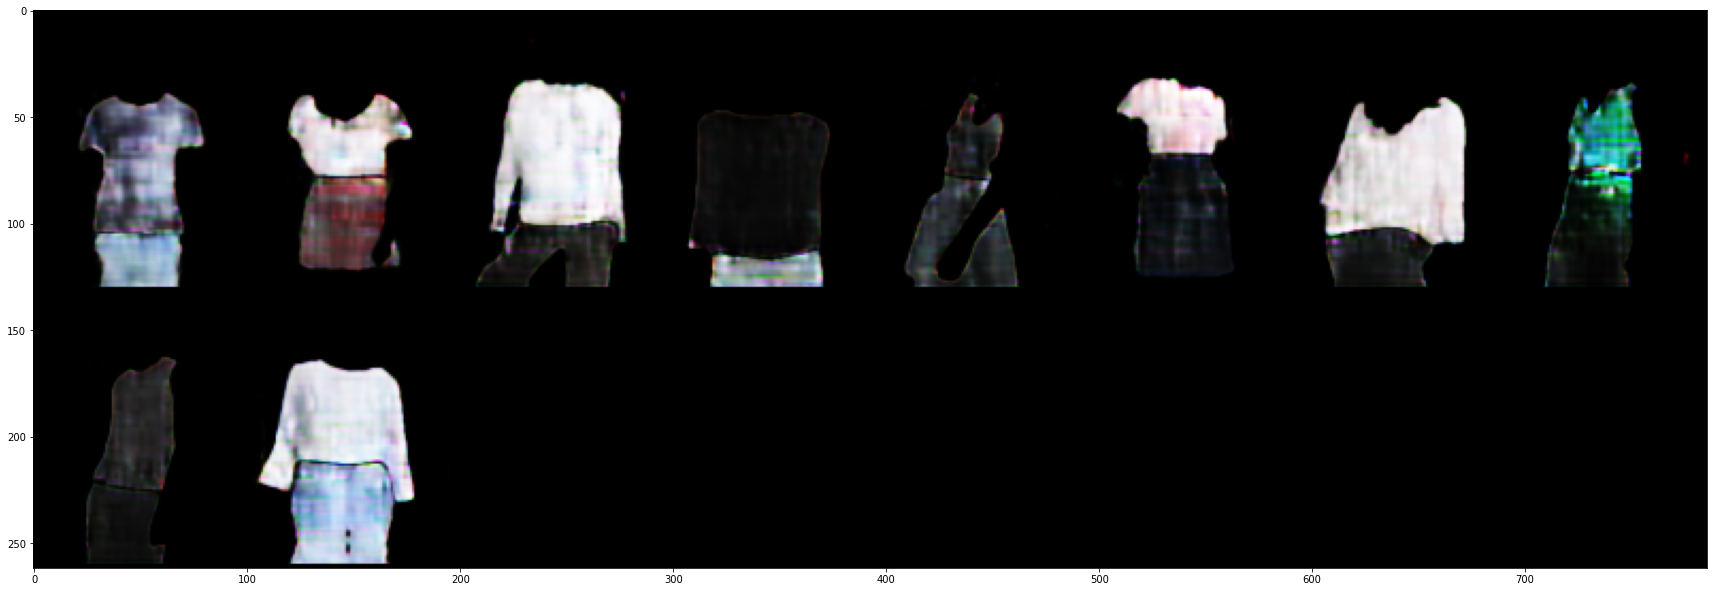

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(np.transpose(vutils.make_grid((fake).detach().to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
#vutils.save_image(fake[0],"4.jpg")

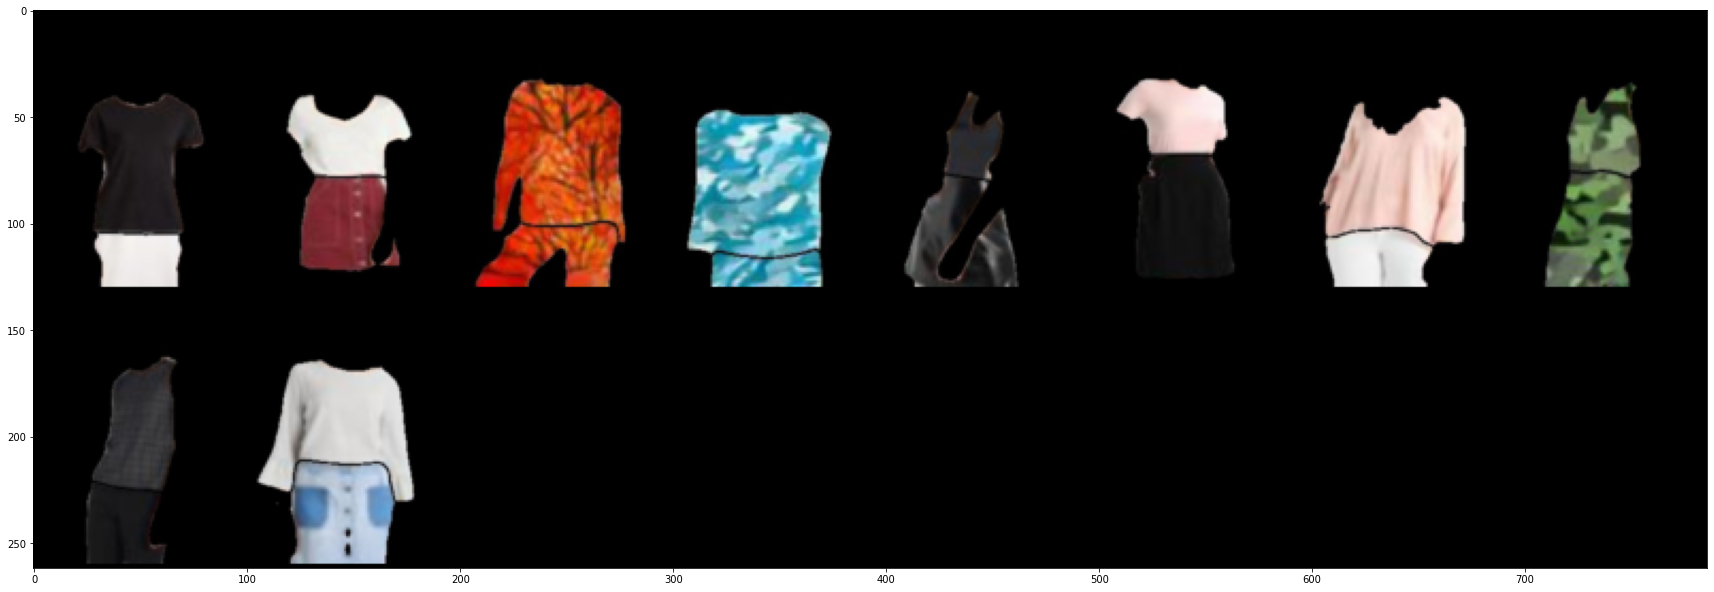

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(np.transpose(vutils.make_grid(item.detach().to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
#vutils.save_image(item[0],"1.jpg")

#テスト


##エンコードなし



In [ ]:
%cd drive/My\ Drive
#dataroot1="smis_left-shoes"
#dataroot2="smis_left-shoes_mask"
dataroot3="test_smis_pants"
dataroot4="test_smis_pants_mask"
#dataroot5="smis_right-shoes"
#dataroot6="smis_right-shoes_mask"
dataroot7="test_smis_skirt"
dataroot8="test_smis_skirt_mask"
dataroot9="test_smis_tops"
dataroot10="test_smis_tops_mask"
dataroot11="good_persons_s"
num_thread=0
batch_size=10
num_epoch=15
img_size=(128,96)
lr=0.0002
b1=0.5
b2=0.999
ngpu=1

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [ ]:
test_pants_dataset=dset.ImageFolder(root=dataroot3,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_pants_mask_dataset=dset.ImageFolder(root=dataroot4,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_skirt_dataset=dset.ImageFolder(root=dataroot7,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_skirt_mask_dataset=dset.ImageFolder(root=dataroot8,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_tops_dataset=dset.ImageFolder(root=dataroot9,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_tops_mask_dataset=dset.ImageFolder(root=dataroot10,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_person_dataset=dset.ImageFolder(root=dataroot11,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))

test_pants_dataloader=torch.utils.data.DataLoader(test_pants_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)    
test_pants_mask_dataloader=torch.utils.data.DataLoader(test_pants_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_dataloader=torch.utils.data.DataLoader(test_skirt_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_mask_dataloader=torch.utils.data.DataLoader(test_skirt_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_dataloader=torch.utils.data.DataLoader(test_tops_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_mask_dataloader=torch.utils.data.DataLoader(test_tops_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_person_dataloader=torch.utils.data.DataLoader(test_person_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)

device=torch.device("cuda:0")

In [ ]:
images=[]
i=0
netG.eval()
for epoch in range(10):
   iter_tops = iter(test_tops_dataloader)
   iter_pants=iter(test_pants_dataloader)
   iter_skirt = iter(test_skirt_dataloader)
   #iter_leftshoes=iter(leftshoes_dataloader)
   #iter_rightshoes=iter(rightshoes_dataloader)
   iter_person=iter(test_person_dataloader)

   iter_tops_mask = iter(test_tops_mask_dataloader)
   iter_pants_mask=iter(test_pants_mask_dataloader)
   iter_skirt_mask= iter(test_skirt_mask_dataloader)
   #iter_leftshoes_mask=iter(leftshoes_mask_dataloader)
   #iter_rightshoes_mask=iter(rightshoes_mask_dataloader)

   t1=time.time()
   for tops_data in test_tops_dataloader:
        #0.バッチデータの取得     
        tops_real_batch=next(iter_tops)
        pants_real_batch=next(iter_pants)
        skirt_real_batch=next(iter_skirt)
        #leftshoes_real_batch=next(iter_leftshoes)
        #rightshoes_real_batch=next(iter_rightshoes)
        person_real_batch=next(iter_person)

        tops_mask_real_batch=next(iter_tops_mask)
        pants_mask_real_batch=next(iter_pants_mask)
        skirt_mask_real_batch=next(iter_skirt_mask)
        #leftshoes_mask_real_batch=next(iter_leftshoes_mask)
        #rightshoes_mask_real_batch=next(iter_rightshoes_mask)
       
        tops=tops_real_batch[0].to(device)              #[][][][]
        pants=pants_real_batch[0].to(device)      #[][][][]
        skirt=skirt_real_batch[0].to(device)  
        #leftshoes=leftshoes_real_batch[0].to(device)            #[][][][]
        #rightshoes=rightshoes_real_batch[0].to(device) #[][][][]
        person=person_real_batch[0].to(device)

        tops_mask=tops_mask_real_batch[0].to(device)              #[][][][]
        pants_mask=pants_mask_real_batch[0].to(device)      #[][][][]
        skirt_mask=skirt_mask_real_batch[0].to(device)  
        #leftshoes_mask=leftshoes_mask_real_batch[0].to(device)            #[][][][]
        #rightshoes_mask=rightshoes_mask_real_batch[0].to(device) #[][][][]

        b_size = tops.size(0)#バッチサイズを計算
        #print(b_size)
        
        
        #データの連結
        input=torch.cat([tops,pants,skirt],dim=1)
        seg=torch.cat([tops_mask,pants_mask,skirt_mask],dim=1)
        
        #fakeを生成
        fake,z=netG(input,seg,_,test=True)
        fake_image=overlay(person,fake,tops_mask,pants_mask,skirt_mask)
        vutils.save_image(fake_image[1],f"result/1_{epoch}.jpg")
        vutils.save_image(fake_image[5],f"result/5_{epoch}.jpg")
        vutils.save_image(fake_image[6],f"result/6_{epoch}.jpg")
        vutils.save_image(fake_image[7],f"result/7_{epoch}.jpg")
        vutils.save_image(fake_image[8],f"result/8_{epoch}.jpg")
        
        

In [ ]:
images=[]
for i in range(10):
  images.append(imageio.imread(f"result/1_{i}.jpg"))
imageio.mimsave("gifs/1.gif",images)

images=[]
for i in range(10):
  images.append(imageio.imread(f"result/5_{i}.jpg"))
imageio.mimsave("gifs/5.gif",images)

images=[]
for i in range(10):
  images.append(imageio.imread(f"result/6_{i}.jpg"))
imageio.mimsave("gifs/6.gif",images)

images=[]
for i in range(10):
  images.append(imageio.imread(f"result/7_{i}.jpg"))
imageio.mimsave("gifs/7.gif",images)

images=[]
for i in range(10):
  images.append(imageio.imread(f"result/8_{i}.jpg"))
imageio.mimsave("gifs/8.gif",images)

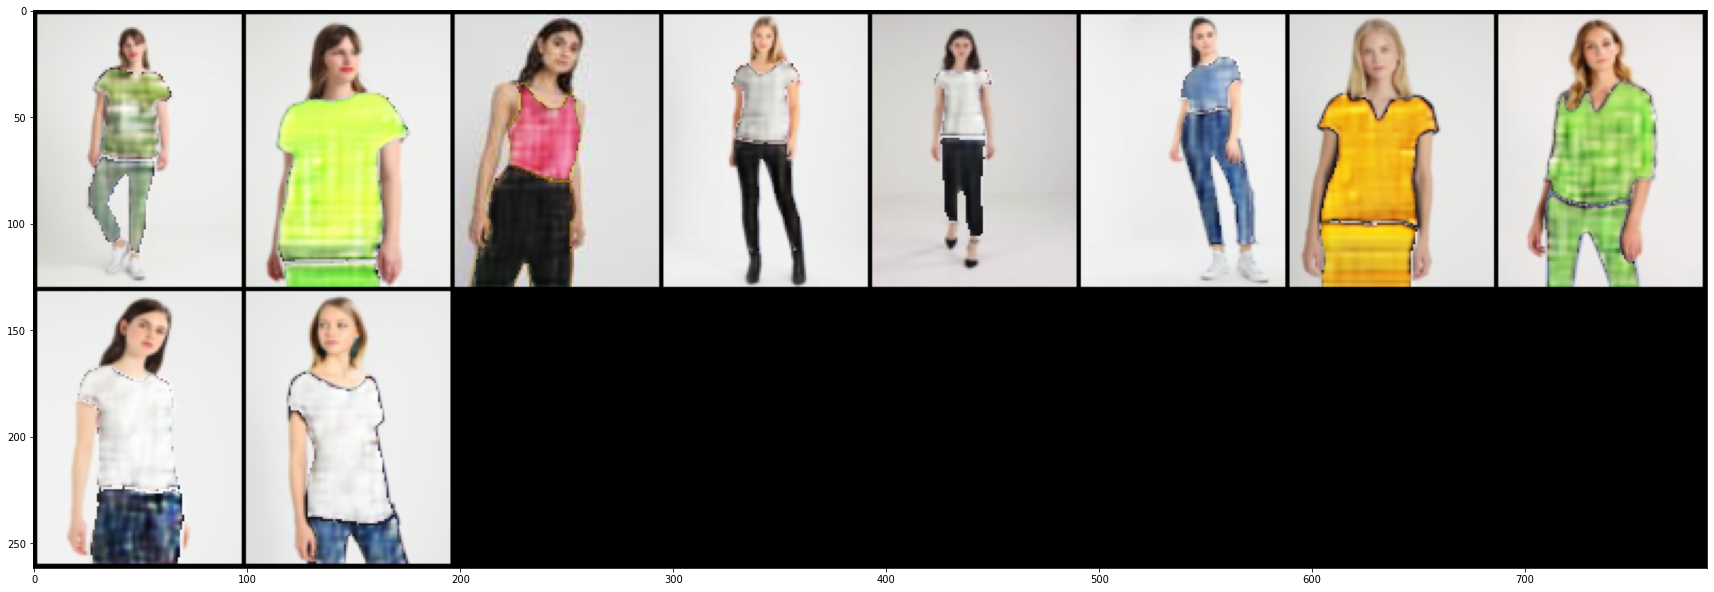

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach().to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))

##エンコードあり


In [ ]:
%cd drive/My\ Drive

dataroot3="yellow_pants"
dataroot4="test_smis_pants_mask"
dataroot7="yellow_skirt"
dataroot8="test_smis_skirt_mask"
dataroot9="yellow_tops"
dataroot10="test_smis_tops_mask"
dataroot11="good_persons_s"
num_thread=0
batch_size=11
num_epoch=15
img_size=(128,96)
lr=0.0002
b1=0.5
b2=0.999
ngpu=1

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [ ]:
test_pants_dataset=dset.ImageFolder(root=dataroot3,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_pants_mask_dataset=dset.ImageFolder(root=dataroot4,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_skirt_dataset=dset.ImageFolder(root=dataroot7,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_skirt_mask_dataset=dset.ImageFolder(root=dataroot8,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_tops_dataset=dset.ImageFolder(root=dataroot9,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))
test_tops_mask_dataset=dset.ImageFolder(root=dataroot10,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_person_dataset=dset.ImageFolder(root=dataroot11,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))

test_pants_dataloader=torch.utils.data.DataLoader(test_pants_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)    
test_pants_mask_dataloader=torch.utils.data.DataLoader(test_pants_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_dataloader=torch.utils.data.DataLoader(test_skirt_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_mask_dataloader=torch.utils.data.DataLoader(test_skirt_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_dataloader=torch.utils.data.DataLoader(test_tops_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_mask_dataloader=torch.utils.data.DataLoader(test_tops_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_person_dataloader=torch.utils.data.DataLoader(test_person_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)

device=torch.device("cuda:0")

In [ ]:
netG.eval()
for epoch in range(1):
   iter_tops = iter(test_tops_dataloader)
   iter_pants=iter(test_pants_dataloader)
   iter_skirt = iter(test_skirt_dataloader)

   for tops_data in test_tops_dataloader:
        #0.バッチデータの取得     
        tops_real_batch=next(iter_tops)
        pants_real_batch=next(iter_pants)
        skirt_real_batch=next(iter_skirt)
       
        tops=tops_real_batch[0].to(device)              #[][][][]
        pants=pants_real_batch[0].to(device)      #[][][][]
        skirt=skirt_real_batch[0].to(device)  

        b_size = tops.size(0)#バッチサイズを計算
          
        #データの連結
        input=torch.cat([tops,pants,skirt],dim=1)
       
        #fakeを生成
        z=netG(input,_,_,encodeonly=True)
        print(z.mean())

tensor(-0.0525, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
images=[]
i=0

for epoch in range(1):
   iter_person=iter(test_person_dataloader)

   iter_tops_mask = iter(test_tops_mask_dataloader)
   iter_pants_mask=iter(test_pants_mask_dataloader)
   iter_skirt_mask= iter(test_skirt_mask_dataloader)
  
   t1=time.time()
   for tops_data in test_tops_mask_dataloader:
        #0.バッチデータの取得     
        person_real_batch=next(iter_person)
        tops_mask_real_batch=next(iter_tops_mask)
        pants_mask_real_batch=next(iter_pants_mask)
        skirt_mask_real_batch=next(iter_skirt_mask)

        person=person_real_batch[0].to(device)
        tops_mask=tops_mask_real_batch[0].to(device)              #[][][][]
        pants_mask=pants_mask_real_batch[0].to(device)      #[][][][]
        skirt_mask=skirt_mask_real_batch[0].to(device)  
        
        b_size = tops.size(0)#バッチサイズを計算
        #print(b_size)
        
        
        #データの連結
        seg=torch.cat([tops_mask,pants_mask,skirt_mask],dim=1)
        z2=torch.cat([z,z],dim=0)
        z4=torch.cat([z2,z2],dim=0)
        z8=torch.cat([z4,z4],dim=0)
        z10=torch.cat([z8,z2],dim=0)
        z=torch.cat([z10,z],dim=0)
        print(z.size())
        print(seg.size())


        
        #fakeを生成
        fake=netG(input,seg,z,pre=True)
        fake_image=overlay(person,fake,tops_mask,pants_mask,skirt_mask)
print(fake_image.mean())

torch.Size([11, 24, 4, 3])
torch.Size([11, 3, 128, 96])
tensor(0.7855, device='cuda:0', grad_fn=<MeanBackward0>)


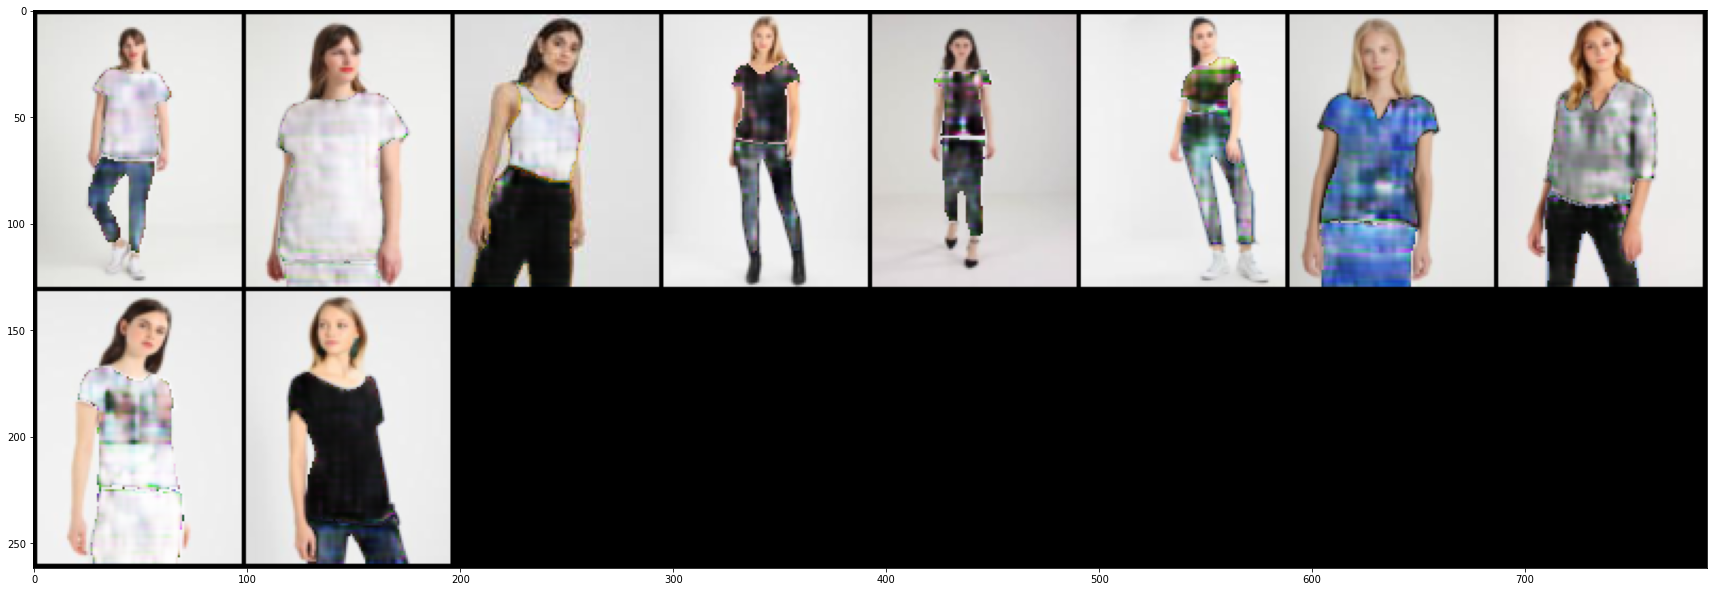

In [ ]:
plt.figure(figsize=(30,30))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach().to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))
vutils.save_image(fake_image[2],"0.png")
#print(fake_image)

##モーフィング


In [ ]:
a=z

In [ ]:
b=z

In [ ]:
images=[]
i=0
n=20
for epoch in range(n):
   iter_tops = iter(test_tops_dataloader)
   iter_pants=iter(test_pants_dataloader)
   iter_skirt = iter(test_skirt_dataloader)
   #iter_leftshoes=iter(leftshoes_dataloader)
   #iter_rightshoes=iter(rightshoes_dataloader)
   iter_person=iter(test_person_dataloader)

   iter_tops_mask = iter(test_tops_mask_dataloader)
   iter_pants_mask=iter(test_pants_mask_dataloader)
   iter_skirt_mask= iter(test_skirt_mask_dataloader)
   #iter_leftshoes_mask=iter(leftshoes_mask_dataloader)
   #iter_rightshoes_mask=iter(rightshoes_mask_dataloader)

   t1=time.time()
   for tops_data in test_tops_dataloader:
        #0.バッチデータの取得     
        tops_real_batch=next(iter_tops)
        pants_real_batch=next(iter_pants)
        skirt_real_batch=next(iter_skirt)
        #leftshoes_real_batch=next(iter_leftshoes)
        #rightshoes_real_batch=next(iter_rightshoes)
        person_real_batch=next(iter_person)

        tops_mask_real_batch=next(iter_tops_mask)
        pants_mask_real_batch=next(iter_pants_mask)
        skirt_mask_real_batch=next(iter_skirt_mask)
        #leftshoes_mask_real_batch=next(iter_leftshoes_mask)
        #rightshoes_mask_real_batch=next(iter_rightshoes_mask)
       
        tops=tops_real_batch[0].to(device)              #[][][][]
        pants=pants_real_batch[0].to(device)      #[][][][]
        skirt=skirt_real_batch[0].to(device)  
        #leftshoes=leftshoes_real_batch[0].to(device)            #[][][][]
        #rightshoes=rightshoes_real_batch[0].to(device) #[][][][]
        person=person_real_batch[0].to(device)

        tops_mask=tops_mask_real_batch[0].to(device)              #[][][][]
        pants_mask=pants_mask_real_batch[0].to(device)      #[][][][]
        skirt_mask=skirt_mask_real_batch[0].to(device)  
        #leftshoes_mask=leftshoes_mask_real_batch[0].to(device)            #[][][][]
        #rightshoes_mask=rightshoes_mask_real_batch[0].to(device) #[][][][]

        b_size = tops.size(0)#バッチサイズを計算
        #print(b_size)
        
        
        #データの連結
        input=torch.cat([tops,pants,skirt],dim=1)
        seg=torch.cat([tops_mask,pants_mask,skirt_mask],dim=1)
        
        #fakeを生成
        alpha=epoch/n
        Z=a*(1-alpha)+b*alpha
        fake=netG(input,seg,Z,pre=True)
        fake_image=overlay(person,fake,tops_mask,pants_mask,skirt_mask)
        vutils.save_image(fake_image[1],f"result/1_{epoch}.jpg")
        vutils.save_image(fake_image[5],f"result/5_{epoch}.jpg")
        vutils.save_image(fake_image[6],f"result/6_{epoch}.jpg")
        vutils.save_image(fake_image[7],f"result/7_{epoch}.jpg")
        vutils.save_image(fake_image[8],f"result/8_{epoch}.jpg")

In [ ]:
images=[]
for i in range(n):
  images.append(imageio.imread(f"result/1_{i}.jpg"))
imageio.mimsave("gifs/1.gif",images)

images=[]
for i in range(n):
  images.append(imageio.imread(f"result/5_{i}.jpg"))
imageio.mimsave("gifs/5.gif",images)

images=[]
for i in range(n):
  images.append(imageio.imread(f"result/6_{i}.jpg"))
imageio.mimsave("gifs/6.gif",images)

images=[]
for i in range(n):
  images.append(imageio.imread(f"result/7_{i}.jpg"))
imageio.mimsave("gifs/7.gif",images)

images=[]
for i in range(n):
  images.append(imageio.imread(f"result/8_{i}.jpg"))
imageio.mimsave("gifs/8.gif",images)

#損失を表示

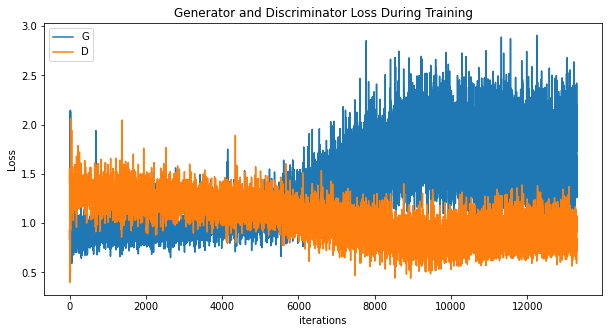

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(Generator_losses,label="G")
plt.plot( Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("graph01")
plt.show()

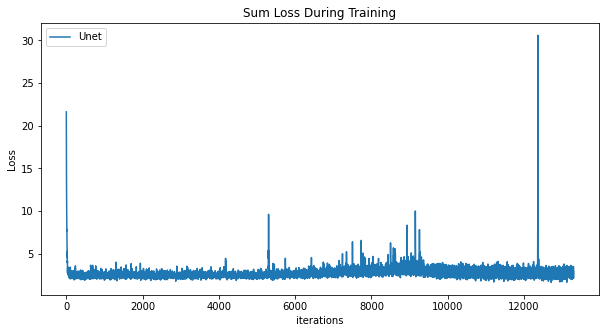

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("Sum Loss During Training")
plt.plot(Sum_losses,label="Unet")
#plt.plot( Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("graph02")
plt.show()

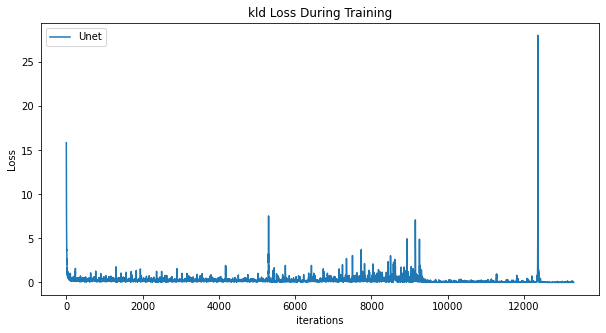

tensor(0.0111, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("kld Loss During Training")
plt.plot(kld_losses,label="Unet")
#plt.plot( Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
print(kld_losses[-1])

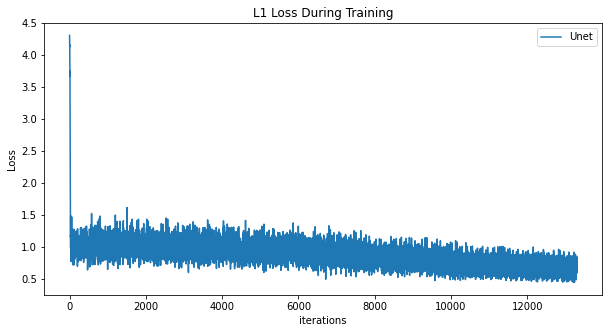

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(L1_losses,label="Unet")
#plt.plot( Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.savefig("graph02")
plt.legend()
plt.show()

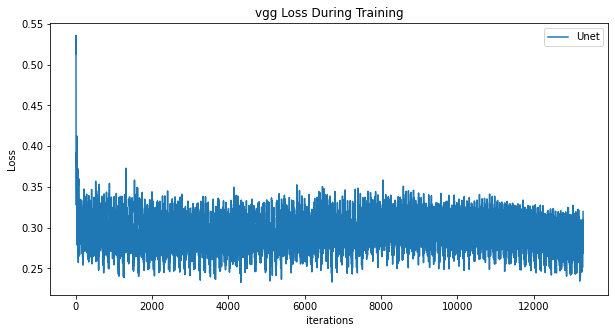

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("vgg Loss During Training")
plt.plot(vgg_losses,label="Unet")
#plt.plot( Discriminator_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.savefig("graph03")
plt.legend()
plt.show()

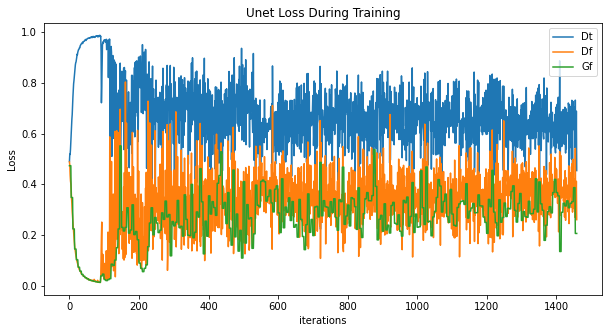

In [ ]:
fig=plt.figure(figsize=(10,5))
plt.title("Unet Loss During Training")
plt.plot(judge1,label="Dt")
plt.plot(judge2,label="Df")
plt.plot(judge3,label="Gf")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

#退避

In [ ]:
%cd ..

/content


In [ ]:
%cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
def avoid_G():    
    PATHUnet='drive/My Drive/models/encoderdecoder(0.00002,0.5,0.999,1:5,batch16,L1,item,pool,1:1)_5.pth'
    torch.save({
            'epoch': epoch,
            #'image':img_list,
            'Sum_losses':Sum_losses,
            'Generator':Generator_losses,
            'Vgg':vgg_losses,
            'kld':kld_losses,
            'L1':L1_losses,
            'judge1':judge1,
            'judge2':judge2,
            'judge3':judge3,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizernetG.state_dict(),
            'criterion1':Ladv.state_dict(),
            'criterion2':L1.state_dict(),
            'criterion3':Lper.state_dict()

            }, PATHUnet)
def avoid_D():
    PATHD='drive/My Drive/models/discriminator(0.00002,0.5,0.999,1:5,batch16,L1,item,pool,1:1)_5.pth'
    torch.save({
            'Disciriminator_losses':Discriminator_losses,
            'model_state_dict': netD.state_dict(),
            'optimizer_state_dict': optimizernetD.state_dict()
            }, PATHD)

In [ ]:
avoid_G()
avoid_D()

NameError: ignored

In [ ]:
print(epoch)

9


#ロード

In [ ]:
PATHG='drive/My Drive/models/encoderdecoder(0.00002,0.5,0.999,1:5,batch16,L1,item,pool,1:1)_5.pth'
#Unet = EncoderDecoder(ngpu).to(device)
optimizernetG= optim.Adam(netG.parameters(),lr=lr,betas=(b1,b2))
Ladv=nn.BCELoss()
L1=nn.L1Loss()
Lper=Vgg19Loss().to(device)

checkpoint = torch.load(PATHG)
netG.load_state_dict(checkpoint['model_state_dict'])
optimizernetG.load_state_dict(checkpoint['optimizer_state_dict'])
Ladv.load_state_dict(checkpoint['criterion1'])
L1.load_state_dict(checkpoint['criterion2'])
Lper.load_state_dict(checkpoint['criterion3'])
epoch = checkpoint['epoch']
#img_list=checkpoint['image']
Sum_losses=checkpoint['Sum_losses']
Generator_losses=checkpoint['Generator']
kld_losses=checkpoint['kld']
vgg_losses=checkpoint['Vgg']
L1_losses=checkpoint["L1"]
judge1=checkpoint['judge1']
judge2=checkpoint['judge2']
judge3=checkpoint['judge3']

In [ ]:
PATHD='drive/My Drive/models/discriminator(0.00002,0.5,0.999,1:5,batch16,L1,item,pool,1:1)_5.pth'
#Discriminator=Discriminator(ngpu).to(device)
optimizernetD=optim.Adam(netD.parameters(),lr=lr,betas=(b1,b2))


checkpoint = torch.load(PATHD)
netD.load_state_dict(checkpoint['model_state_dict'])
optimizernetD.load_state_dict(checkpoint['optimizer_state_dict'])
Discriminator_losses=checkpoint['Disciriminator_losses']

#実際テスト

##前処理

In [ ]:
%cd ..

In [ ]:
%cd drive/My\ Drive/segment_geter

/content/drive/.shortcut-targets-by-id/1tfrENypVAz2EOIaxwrtyJHEJNR3Mex2t/segment_geter


In [ ]:
!pip install ninja

     |████████████████████████████████| 112kB 7.6MB/s 


In [ ]:
!python simple_extractor.py --dataset lip --model-restore exp-schp-201908261155-lip.pth --input-dir data/LIP/img --output-dir data/out/

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

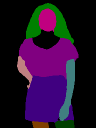

(128, 96, 3)


True

In [ ]:
name=5
img1=cv2.imread(f"data/out/{name}..png")
img2=cv2.imread(f"data/LIP/img/{name}.jpeg")
if img1.shape[0]>img1.shape[1]:
    temp=int(img1.shape[1]/96)
    w=temp*96
    h=temp*128
    if h>img1.shape[0]:
      w=w/2
      h=h/2

    y2=img1.shape[0]-(img1.shape[0]-h)/2
    y1=img1.shape[0]-((img1.shape[0]-h)/2)-h
    if (y1-round(y1))==0.5:
      y1=y1-0.5
      y2=y2+0.5

    x2=img1.shape[1]-(img1.shape[1]-w)/2
    x1=img1.shape[1]-((img1.shape[1]-w)/2)-w
    if (x1-round(x1))==0.5:
      x1=x1+0.5
      x2=x2+0.5
    img1=img1[int(y1):int(y2),int(x1):int(x2),:]
    img2=img2[int(y1):int(y2),int(x1):int(x2),:]
    img1=cv2.resize(img1,(96,128))
    img2=cv2.resize(img2,(96,128))

elif img1.shape[0]<img1.shape[1]:
    temp=int(img1.shape[0]/128)
    w=temp*96
    h=temp*128
    if w>img1.shape[1]:
      w=w/2
      h=h/2

    y2=img1.shape[0]-(img1.shape[0]-h)/2
    y1=img1.shape[0]-((img1.shape[0]-h)/2)-h
    if (y1-round(y1))==0.5:
      y1=y1-0.5
      y2=y2+0.5

    x2=img1.shape[1]-(img1.shape[1]-w)/2
    x1=img1.shape[1]-((img1.shape[1]-w)/2)-w
    if (x1-round(x1))==0.5:
      x1=x1+0.5
      x2=x2+0.5
    img1=img1[int(y1):int(y2),int(x1):int(x2),:]
    img2=img2[int(y1):int(y2),int(x1):int(x2),:]
    img1=cv2.resize(img1,(96,128))
    img2=cv2.resize(img2,(96,128))

cv2_imshow(img1)
print(img2.shape)
cv2.imwrite(f"data/persons/person/{name}.jpg",img2)



img1=img1.transpose(2,0,1)
np.set_printoptions(threshold=np.inf)
zero=np.zeros((1,img1.shape[1],img1.shape[2]))
for i in range(img1.shape[1]):
    for j in range(img1.shape[2]):
      if img1[0][i][j]==128 and img1[1][i][j]==0 and img1[2][i][j]==128:
        zero[0][i][j]=1
  
mask=zero.transpose(1,2,0)
cv2.imwrite(f"tops_mask/mask/{name}.jpg",mask*255)

zero=np.zeros((1,img1.shape[1],img1.shape[2]))
for i in range(img1.shape[1]):
    for j in range(img1.shape[2]):
      if img1[0][i][j]==0 and img1[1][i][j]==0 and img1[2][i][j]==192:
        zero[0][i][j]=1
  
mask=zero.transpose(1,2,0)
cv2.imwrite(f"pants_mask/mask/{name}.jpg",mask*255)

zero=np.zeros((1,img1.shape[1],img1.shape[2]))
for i in range(img1.shape[1]):
    for j in range(img1.shape[2]):
      if img1[0][i][j]==128 and img1[1][i][j]==0 and img1[2][i][j]==64:
        zero[0][i][j]=1
  
mask=zero.transpose(1,2,0)
cv2.imwrite(f"skirt_mask/mask/{name}.jpg",mask*255)

##テスト

In [ ]:
%cd ..

/content


In [ ]:
%cd drive/My\ Drive

/content/drive/My Drive


In [ ]:
#dataroot1="smis_left-shoes"
#dataroot2="smis_left-shoes_mask"
#dataroot3="test_smis_pants"
dataroot4="segment_geter/pants_mask"
#dataroot5="smis_right-shoes"
#dataroot6="smis_right-shoes_mask"
#dataroot7="test_smis_skirt"
dataroot8="segment_geter/skirt_mask"
#dataroot9="test_smis_tops"
dataroot10="segment_geter/tops_mask"
dataroot11="segment_geter/data/persons"
num_thread=0
batch_size=10
num_epoch=15
img_size=(128,96)
lr=0.0002
b1=0.5
b2=0.999
ngpu=1

In [ ]:

test_pants_mask_dataset=dset.ImageFolder(root=dataroot4,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))

test_skirt_mask_dataset=dset.ImageFolder(root=dataroot8,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))

test_tops_mask_dataset=dset.ImageFolder(root=dataroot10,transform=transforms.Compose([transforms.Resize(img_size),transforms.Grayscale(),transforms.ToTensor(),]))
test_person_dataset=dset.ImageFolder(root=dataroot11,transform=transforms.Compose([transforms.Resize(img_size),transforms.ToTensor(),]))

test_pants_dataloader=torch.utils.data.DataLoader(test_pants_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)    
test_pants_mask_dataloader=torch.utils.data.DataLoader(test_pants_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_dataloader=torch.utils.data.DataLoader(test_skirt_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_skirt_mask_dataloader=torch.utils.data.DataLoader(test_skirt_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_dataloader=torch.utils.data.DataLoader(test_tops_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_tops_mask_dataloader=torch.utils.data.DataLoader(test_tops_mask_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)
test_person_dataloader=torch.utils.data.DataLoader(test_person_dataset,batch_size=batch_size,shuffle=False,num_workers=num_thread)

device=torch.device("cuda:0")

In [ ]:
for epoch in range(1):
   
   iter_person=iter(test_person_dataloader)

   iter_tops_mask = iter(test_tops_mask_dataloader)
   iter_pants_mask=iter(test_pants_mask_dataloader)
   iter_skirt_mask= iter(test_skirt_mask_dataloader)
   #iter_leftshoes_mask=iter(leftshoes_mask_dataloader)
   #iter_rightshoes_mask=iter(rightshoes_mask_dataloader)

   t1=time.time()
   for tops_data in test_tops_dataloader:
        #0.バッチデータの取得     
        
        person_real_batch=next(iter_person)

        tops_mask_real_batch=next(iter_tops_mask)
        pants_mask_real_batch=next(iter_pants_mask)
        skirt_mask_real_batch=next(iter_skirt_mask)
        #leftshoes_mask_real_batch=next(iter_leftshoes_mask)
        #rightshoes_mask_real_batch=next(iter_rightshoes_mask)
       
       
        person=person_real_batch[0].to(device)

        tops_mask=tops_mask_real_batch[0].to(device)              #[][][][]
        pants_mask=pants_mask_real_batch[0].to(device)      #[][][][]
        skirt_mask=skirt_mask_real_batch[0].to(device)  
        #leftshoes_mask=leftshoes_mask_real_batch[0].to(device)            #[][][][]
        #rightshoes_mask=rightshoes_mask_real_batch[0].to(device) #[][][][]

        b_size = tops_mask.size(0)#バッチサイズを計算
        #print(b_size)
        
        
        #データの連結
        seg=torch.cat([tops_mask,pants_mask,skirt_mask],dim=1)
        
        #fakeを生成
        fake=netG(_,seg,_,test=True)
        fake_image=overlay(person,fake,tops_mask,pants_mask,skirt_mask)

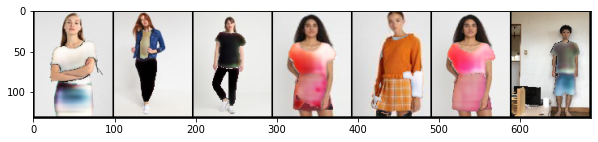

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(vutils.make_grid(fake_image.detach().to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)))